DHRobot: Panda (by Franka Emika), 7 joints (RRRRRRR), dynamics, geometry, modified DH parameters
┏━━━━━━━━┳━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓
┃ aⱼ₋₁   ┃  ⍺ⱼ₋₁  ┃ θⱼ  ┃  dⱼ   ┃   q⁻    ┃   q⁺   ┃
┣━━━━━━━━╋━━━━━━━━╋━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━┫
┃    0.0 ┃   0.0° ┃  q1 ┃ 0.333 ┃ -166.0° ┃ 166.0° ┃
┃    0.0 ┃ -90.0° ┃  q2 ┃   0.0 ┃ -101.0° ┃ 101.0° ┃
┃    0.0 ┃  90.0° ┃  q3 ┃ 0.316 ┃ -166.0° ┃ 166.0° ┃
┃ 0.0825 ┃  90.0° ┃  q4 ┃   0.0 ┃ -176.0° ┃  -4.0° ┃
┃-0.0825 ┃ -90.0° ┃  q5 ┃ 0.384 ┃ -166.0° ┃ 166.0° ┃
┃    0.0 ┃  90.0° ┃  q6 ┃   0.0 ┃   -1.0° ┃ 215.0° ┃
┃  0.088 ┃  90.0° ┃  q7 ┃ 0.107 ┃ -166.0° ┃ 166.0° ┃
┗━━━━━━━━┻━━━━━━━━┻━━━━━┻━━━━━━━┻━━━━━━━━━┻━━━━━━━━┛

┌─────┬──────┐
│tool │ None │
└─────┴──────┘

┌─────┬─────┬────────┬─────┬───────┬─────┬───────┬──────┐
│name │ q0  │ q1     │ q2  │ q3    │ q4  │ q5    │ q6   │
├─────┼─────┼────────┼─────┼───────┼─────┼───────┼──────┤
│  qz │  0° │  0°    │  0° │  0°   │  0° │  0°   │  0°  │
│  qr │  0° │ -17.2° │  0° │ -126° │  0° 

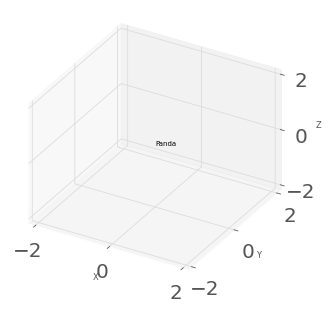

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy.integrate as integ
import sympy as sp
import sympy.plotting as splot
import pandas as pd

from scipy import misc
from scipy.spatial import ConvexHull
from scipy.optimize import least_squares,minimize,Bounds,NonlinearConstraint


from numpy import cos,sin,pi, arccos
from numpy.linalg import inv

from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

from sympy.sets import Interval

from sklearn import datasets

from sympy import solveset, symbols, Interval, Min



from spatialmath import *
from roboticstoolbox import *

panda = models.DH.Panda()
q_neutral=(panda.qlim[0]+panda.qlim[1])/2
print(panda)
print("q_neutral = ",q_neutral)
panda.plot(q_neutral,block=False)



ft=24 ; #Police size

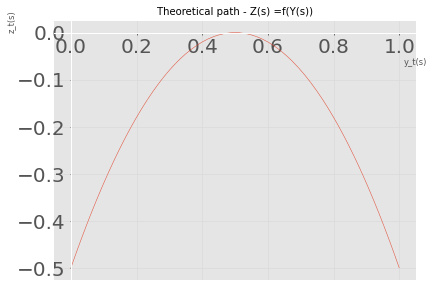

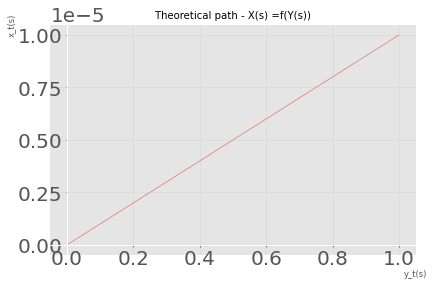

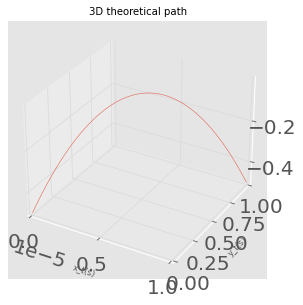

x_t(s) =  1.0e-5*s
y_t(s) =  s
z_t(s) =  -2*(s - 0.5)**2
X_t_max =	 1.00000000000000e-5
X_t_min =	 0
Y_t_max =	 1
Y_t_min =	 0
Z_t_max =	 0
Z_t_min =	 -0.5


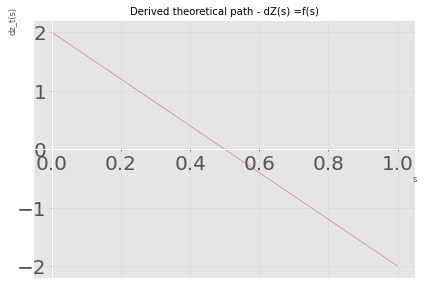


dx_t(s)/ds =  1.00000000000000e-5
dy_t(s)/ds =  1
dz_t(s)/ds =  2.0 - 4*s


In [23]:
n_path=15; # path number in "TrajectoryCharacteristics.ods" file
# VARIABLES
nb_points = 150 ;

#A*s+B*sp.sin(f1*s)+C*sp.cos(f1*s)+D*sp.sin(f2*s)**2+E*sp.cos(f2*s)**2+F*sp.sin(f3*s)**3+G*sp.cos(f3*s)**3 + H*s**2 + I*s**3
A=0;         #        #0
B=0;         # sin    #0
C=0;         # cos    #3/2
D=0;         # sin^2  #0
E=0;         # cos^2  #2
F=0;         # sin^3  #0
G=0;         # cos^3  #0
H=-2;         # x^2
I=0          # x^3

f1=3*sp.pi;    #6*sp.pi # Here is not frequency but pulsation, it should be written omega_1
f11=0;    #6*sp.pi
f12=0;    #6*sp.pi
f2=0;        #2*sp.pi
f3=0;        #0

dA=0;
dH=-0.5;
dI=0;

X_start=0.5;
Y_start=-0.2;
Z_start=0.2;

depth=1e-10; # trajectory depth in real space X
width=0.4; # trajectory width in real space Y
height=0.15 # trajectory height in real space Z


Z_t_max = 0 #sp.maximum(Z_t(s), s, S_Interval) # too complicated to compute

Z_t_min = -0.5 #sp.minimum(Z_t(s), s, S_Interval) # too complicated to compute


# Curvilinear abscissa
s = sp.Symbol('s') 
s_eval=np.arange(0,1,1/nb_points);
s_max = 1
s_min = 0
S_Interval=Interval(s_min,s_max)

# THEORETICAL FUNCTIONS
def X_t(s):
    return 1e-5*s
    #return 1e-5*s+A*s+B*sp.sin(f1*s)+C*sp.cos(f1*s)
    #return A*s+B*sp.sin(f1*s)+C*sp.cos(f1*s)
def Y_t(s):
    return s
def Z_t(s):
    #return 2*s
    return A*(dA+s)+B*sp.sin(f1*s)+C*sp.cos(f1*s)+D*sp.sin(f2*s)**2+E*sp.cos(f2*s)**2+F*sp.sin(f3*s)**3+G*sp.cos(f3*s)**3 + H*(dH+s)**2 + I*(dI+s)**3;
    #return A*s+B*sp.atan(sp.atan(sp.cos(f11*s)))+C*sp.atan(sp.atan(sp.cos(f12*s)))+D*sp.atan(sp.atan(sp.sin(f2*s)))**2+E*sp.atan(sp.atan(sp.cos(f2*s)))**2+F*sp.atan(sp.atan(sp.sin(f3*s)))**3+G*sp.atan(sp.atan(sp.cos(f3*s)))**3;

# COMPUTING
splot.plot_parametric((Y_t(s),Z_t(s)),(s,s_min,s_max),xlabel="y_t(s)",ylabel='z_t(s)', title='Theoretical path - Z(s) =f(Y(s))')
splot.plot_parametric((Y_t(s),X_t(s)),(s,s_min,s_max),xlabel="y_t(s)",ylabel='x_t(s)', title='Theoretical path - X(s) =f(Y(s))')
splot.plot3d_parametric_line(X_t(s),Y_t(s),Z_t(s),(s,s_min,s_max),xlabel="x_t(s)",ylabel='y_t(s)',zlabel='z_t(s)', title='3D theoretical path')
print("x_t(s) = ",X_t(s))
print("y_t(s) = ",Y_t(s))
print("z_t(s) = ",Z_t(s))

# Computing Max Min of theoretical functions
X_t_max = sp.maximum(X_t(s), s, S_Interval)
print('X_t_max =\t',X_t_max)
X_t_min = sp.minimum(X_t(s), s, S_Interval)
print('X_t_min =\t',X_t_min)
Y_t_max = sp.maximum(Y_t(s), s, S_Interval)
print('Y_t_max =\t',Y_t_max)
Y_t_min = sp.minimum(Y_t(s), s, S_Interval)
print('Y_t_min =\t',Y_t_min)
print('Z_t_max =\t',Z_t_max)
print('Z_t_min =\t',Z_t_min)

# DERIVATIVE
dx_t=sp.diff(X_t(s),s)
dy_t=sp.diff(Y_t(s),s)
dz_t=sp.diff(Z_t(s),s)

splot.plot(dz_t,(s,0,1),xlabel="s",ylabel='dz_t(s)', title='Derived theoretical path - dZ(s) =f(s)')
print("\ndx_t(s)/ds = ",dx_t)
print("dy_t(s)/ds = ",dy_t)
print("dz_t(s)/ds = ",dz_t)

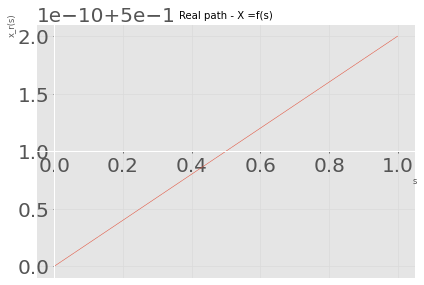

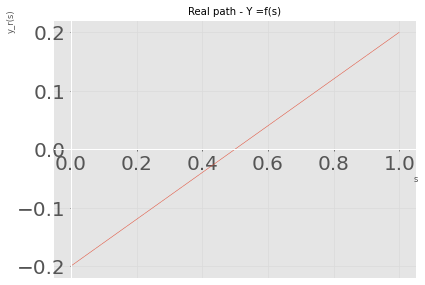

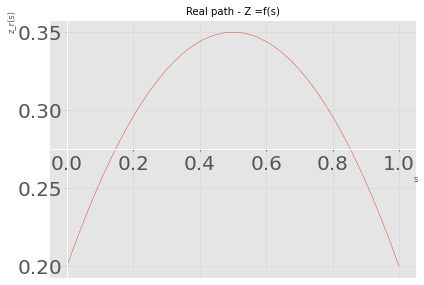

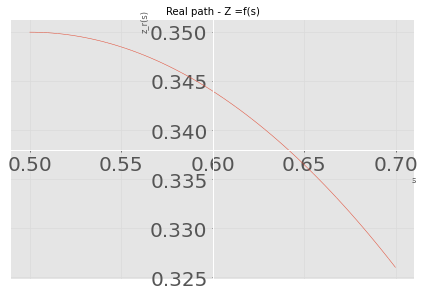

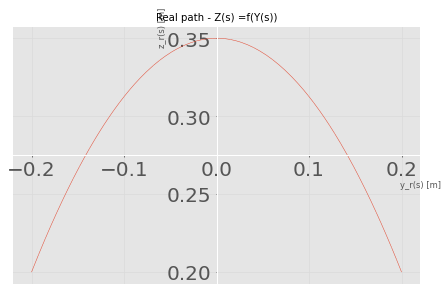

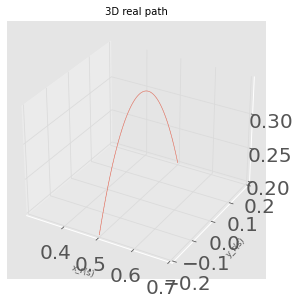

x_r(s) =  2.0e-10*s + 0.5
y_r(s) =  0.4*s - 0.2
z_r(s) =  0.35 - 0.6*(s - 0.5)**2


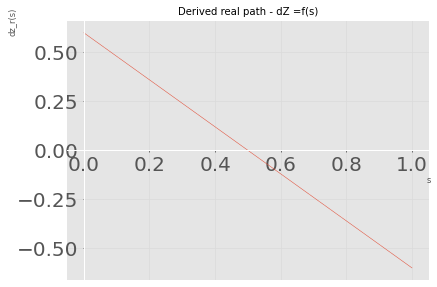


dx_r(s)/ds =  2.00000000000000e-10
dy_r(s)/ds =  0.400000000000000
dz_r(s)/ds =  0.6 - 1.2*s


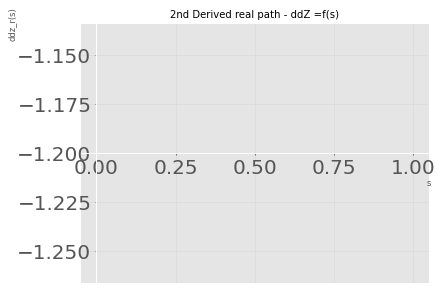


ddx_r(s)/dds =  0
ddy_r(s)/dds =  0
ddz_r(s)/dds =  -1.20000000000000


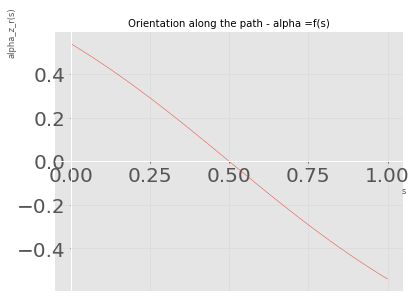


alpha_x_r(s) =  2.00000000000000e-10
alpha_y_r(s) =  0.380506377112365
alpha_z_r(s) =  -atan(1.2*s - 0.6)


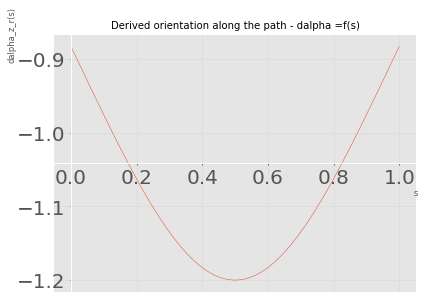


dalpha_x_r(s) =  0
dalpha_y_r(s) =  0
dalpha_z_r(s) =  -1.2/(1.44*(s - 0.5)**2 + 1)


In [24]:
# REAL FUNCTIONS
def X_r(s):
    return (X_t(s)-X_t(0)) * depth / (X_t_max-X_t_min) + X_start +1e-10*s
def Y_r(s):
    return (Y_t(s)-Y_t(0)) * width / (Y_t_max-Y_t_min) + Y_start
def Z_r(s):
    return (Z_t(s)-Z_t(0)) * height / (Z_t_max-Z_t_min) + Z_start


# COMPUTING

plot_size = max(depth,width,height)
splot.plot(X_r(s),(s,s_min,s_max),xlabel="s",ylabel='x_r(s)', title='Real path - X =f(s)')
splot.plot(Y_r(s),(s,s_min,s_max),xlabel="s",ylabel='y_r(s)', title='Real path - Y =f(s)')
splot.plot(Z_r(s),(s,s_min,s_max),xlabel="s",ylabel='z_r(s)', title='Real path - Z =f(s)')
splot.plot(Z_r(s),(s,0.5,0.7),xlabel="s",ylabel='z_r(s)', title='Real path - Z =f(s)')
splot.plot_parametric((Y_r(s),Z_r(s)),(s,s_min,s_max),xlabel="y_r(s) [m]",ylabel='z_r(s) [m]', title='Real path - Z(s) =f(Y(s))')
splot.plot3d_parametric_line(X_r(s),Y_r(s),Z_r(s),(s,s_min,s_max),xlim=[X_start+depth/2-plot_size/2,X_start+depth/2+plot_size/2],ylim=[Y_start+width/2-plot_size/2,Y_start+width/2+plot_size/2],zlim=[0.1,0.9],xlabel="x_r(s)",ylabel='y_r(s)',zlabel='z_r(s)', title='3D real path')
print("x_r(s) = ",X_r(s))
print("y_r(s) = ",Y_r(s))
print("z_r(s) = ",Z_r(s))

x_r=X_r(s)
y_r=Y_r(s)
z_r=Z_r(s)

# DERIVATIVE
dx_r=sp.diff(X_r(s),s)
dy_r=sp.diff(Y_r(s),s)
dz_r=sp.diff(Z_r(s),s)

splot.plot(dz_r,(s,0,1),xlabel="s",ylabel='dz_r(s)', title='Derived real path - dZ =f(s)')
print("\ndx_r(s)/ds = ",dx_r)
print("dy_r(s)/ds = ",dy_r)
print("dz_r(s)/ds = ",dz_r)

# DOUBLE DERIVATIVE
ddx_r=sp.diff(dx_r,s)
ddy_r=sp.diff(dy_r,s)
ddz_r=sp.diff(dz_r,s)

splot.plot(ddz_r,(s,0,1),xlabel="s",ylabel='ddz_r(s)', title='2nd Derived real path - ddZ =f(s)')
print("\nddx_r(s)/dds = ",ddx_r)
print("ddy_r(s)/dds = ",ddy_r)
print("ddz_r(s)/dds = ",ddz_r)

# Curvature

# Angle
alpha_x_r=sp.atan(dx_r)
alpha_y_r=sp.atan(dy_r)
alpha_z_r=sp.atan(dz_r)

splot.plot(alpha_z_r,(s,0,1),xlabel="s",ylabel='alpha_z_r(s)', title='Orientation along the path - alpha =f(s)')
print("\nalpha_x_r(s) = ",alpha_x_r)
print("alpha_y_r(s) = ",alpha_y_r)
print("alpha_z_r(s) = ",alpha_z_r)


# Angle Derivative
dalpha_x_r=sp.diff(alpha_x_r,s)
dalpha_y_r=sp.diff(alpha_y_r,s)
dalpha_z_r=sp.diff(alpha_z_r,s)

splot.plot(dalpha_z_r,(s,0,1),xlabel="s",ylabel='dalpha_z_r(s)', title='Derived orientation along the path - dalpha =f(s)')
print("\ndalpha_x_r(s) = ",dalpha_x_r)
print("dalpha_y_r(s) = ",dalpha_y_r)
print("dalpha_z_r(s) = ",dalpha_z_r)

# Compute frame on each point of the curve

In [25]:
def PathFrame(s_test):
    #print("s test = ",s_test)

    # TANGENT VECTOR
    r12 = -dx_r.evalf(subs={s:s_test})
    r22 = -dy_r.evalf(subs={s:s_test})
    r32 = -dz_r.evalf(subs={s:s_test})
    #r12 = -dx_r.evalf(abscissa_test)
    #r22 = -dy_r.evalf(abscissa_test)
    #r32 = -dz_r.evalf(abscissa_test)

    normT=sp.sqrt(r12**2+r22**2+r32**2)
    r12 = r12/normT
    r22 = r22/normT
    r32 = r32/normT

    #print("T = \n\t",r12,"\n\t",r22,"\n\t",r32)

    # NORMAL VECTOR
    r13 = 0 # on the plane Oy_0z_0, orthogonal to x_0 vector
    if(r32==0):
        r23=0
        r33=1
    else:
        r23 = sp.sqrt(1/((r22/r32)**2+1))
        r33 = -r23 * r22 / r32

    if (r33>0):
        r13=-r13
        r23=-r23
        r33=-r33

    #r23 = sp.sqrt(1/((r22/r12)**2+1))
    #r13 = -r23 * r22 / r12  # on the plane Oy_0x_0, orthogonal to x_0 vector
    #r33 = 0 # on the plane Oy_0x_0, orthogonal to x_0 vector
    #if (r13<0):
    #    r13=-r13
    #    r23=-r23
    #    r33=-r33

    #print("\nN = \n\t",r13,"\n\t",r23,"\n\t",r33)


    # 2nd NORMAL VECTOR
    r11 = r22*r33 - r32*r23
    r21 = r32*r13 - r12*r33
    r31 = r12*r23 - r22*r13
    #print("\nN2 = \n\t",r11,"\n\t",r21,"\n\t",r31)

    # Vectors norms
    #print("\nT norm = \t", sp.sqrt(r12**2+r22**2+r32**2))
    #print("N norm = \t", sp.sqrt(r13**2+r23**2+r33**2))
    #print("N2 norm = \t", sp.sqrt(r11**2+r21**2+r31**2))

    R=[[r11, r12, r13],[r21, r22, r23],[r31, r32, r33]]
    #print("\nR = \n", R[0],"\n", R[1],"\n", R[2])

    detR=R[0][1]*R[1][2]*R[2][0]-R[0][1]*R[2][2]*R[1][0]+R[1][1]*R[2][2]*R[0][0]-R[1][1]*R[0][2]*R[2][0]+R[2][1]*R[0][2]*R[1][0]-R[2][1]*R[1][2]*R[0][0]
    #print("\ndet(R) = ", detR)

    p=[X_r(s_test),Y_r(s_test),Z_r(s_test)]
    #print("\np = \n",p)
    return np.array([R[0]+[p[0]],R[1]+[p[1]],R[2]+[p[2]],[0.0,0.0,0.0,1.0]]).astype(np.float)

### Transform into Spacial Math Package function (example with s=0)

In [26]:
#T_goal=SE3(PathFrame(0),check=False)
#T_goal

### Reference abscissa

In [7]:
nb_points_s=21
s_pas=1/(nb_points_s-1)
s_list = np.arange(0,1+s_pas,s_pas)
s_list

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

### Rotation around wireloop

In [8]:
nb_points_alpha=20
alpha_min=-np.pi
alpha_max=(nb_points_alpha/2-1)*np.pi/(nb_points_alpha/2)
alpha_pas=(alpha_max-alpha_min)/(nb_points_alpha-1)
alpha_list = np.arange(alpha_min,alpha_max+alpha_pas,alpha_pas)
alpha_list

array([-3.14159265, -2.82743339, -2.51327412, -2.19911486, -1.88495559, -1.57079633, -1.25663706, -0.9424778 , -0.62831853, -0.31415927,  0.        ,  0.31415927,  0.62831853,  0.9424778 ,  1.25663706,  1.57079633,  1.88495559,  2.19911486,  2.51327412,  2.82743339])

In [9]:
alpha_list[int(len(alpha_list)/2)]

0.0

### Solve IK

#### Comparing Solvers

In [10]:
x_fail=0.9
y_fail=1.0
z_fail=0.5

frame_test_fail=SE3([x_fail,y_fail,z_fail])

x_success=0.4
y_success=0.2
z_success=0.5

frame_test_success=SE3([x_success,y_success,z_success])

print("T fail: \n",frame_test_fail)
print("T success: \n",frame_test_success)

T fail: 
    1         0         0         0.9       
   0         1         0         1         
   0         0         1         0.5       
   0         0         0         1         

T success: 
    1         0         0         0.4       
   0         1         0         0.2       
   0         0         1         0.5       
   0         0         0         1         



In [10]:
sol_min=panda.ikine_min(frame_test_success,qlim=True,q0=q_neutral)
print(sol_min)
print(sol_min.q>panda.qlim[0])
print(sol_min.q<panda.qlim[1])
print(sol_min.success)

IKsolution(q=array([-1.17401277, -1.24096942,  1.75320633, -2.44146106, -1.65382906,  1.2043837 ,  1.21344649]), success=True, reason='`xtol` termination condition is satisfied.', iterations=316, residual=4.650018342997809e-15)
[ True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True]
True


In [11]:
sol_LMS=panda.ikine_LMS(frame_test_success)
print(sol_LMS)
print(sol_LMS.q>panda.qlim[0])
print(sol_LMS.q<panda.qlim[1])

IKsolution(q=array([ 0.80352587,  0.62197056, -0.45858097, -1.95413946,  0.43274011, -0.66242682, -2.42884694]), success=True, reason=None, iterations=14, residual=9.7319281251447e-14)
[ True  True  True  True  True False  True]
[ True  True  True  True  True  True  True]


### Define functions q solving IK

In [12]:
def q(s,alpha,q0):
    T_goal=SE3(PathFrame(s),check=False)
    T_alpha = SE3.Ry(alpha)
    T_test = T_goal * T_alpha
    sol=panda.ikine_min(T_test,qlim=True,q0=q0, tol=1e-16)
    #print(T_test)
    return sol

def q_frame(T_test,q0):
    sol=panda.ikine_min(T_test, qlim=True,q0=q0, tol=1e-16)
    return sol

### Compute solutions


In [28]:

print('\nSolving IK for the robot along the wireloop for different orientations around it')
print('Computed with:')
print('s = [',s_list[0],'; ',s_list[-1],'] in ', s_list.size,' points')
print('alpha = [',alpha_list[0],'; ',alpha_list[-1],'] in ', alpha_list.size,' points')
q_ini=np.array([ 0.00101961,-0.78475,-0.000276699,-2.35668,-0.00178532,1.57149,0.784751]) # INITIAL GUESS

residual_max = 1e-5

sol_df=pd.DataFrame(columns=['s','alpha','q','success'])

nb_tests=len(s_list) * len(alpha_list)
ind=0

for j in range(len(s_list)):
    for k in range(len(alpha_list)):
        
        percentage=(ind/nb_tests*100)
        print(f'Computing: {percentage:.2f} %', end='\r')
        ind+=1
        
        sj=s_list[j]
        alphak=alpha_list[k]
        
        
        sol=q(sj,alphak,q_ini)
        q_ini=sol.q
        success = (sol.success and sol.residual < residual_max)
        if success:
            q_ini=sol.q
        #print('success = ',success)
        #print('s=',sj,'\talpha=',alphak)
        sol_df=sol_df.append(pd.Series([sj,alphak,sol.q,success], index=sol_df.columns), ignore_index=True)
        
    alpha_list=alpha_list[::-1] # reverse alphalist to stay close to the previous solution
                            



Solving IK for the robot along the wireloop for different orientations around it
Computed with:
s = [ 0.0 ;  1.0 ] in  21  points
alpha = [ -3.141592653589793 ;  2.827433388230814 ] in  20  points


### Compute Solution along the path in 1 function


print('\nSolving IK for the robot along the wireloop for different orientations around it')
print('Computed with:')
print('s = [',s_list[0],'; ',s_list[-1],'] in ', s_list.size,' points')
print('alpha = [',alpha_list[0],'; ',alpha_list[-1],'] in ', alpha_list.size,' points')
q_ini=np.array([ 0.00101961,-0.78475,-0.000276699,-2.35668,-0.00178532,1.57149,0.784751]) # INITIAL GUESS

residual_max = 1e-10

sol_path_df=pd.DataFrame(columns=['s','alpha','q','success'])

nb_tests=len(s_list) * len(alpha_list)
ind=0

for j in range(len(s_list)):
    for k in range(len(alpha_list)):
        
        percentage=(ind/nb_tests*100)
        print(f'Computing: {percentage:.2f} %', end='\r')
        ind+=1
        
        sj=s_list[j]
        alphak=alpha_list[k]
        
        alpha_list=alpha_list[::-1] # reverse alphalist to stay close to the previous solution
        
        T_goal=SE3(PathFrame(s),check=False)
        T_alpha = SE3.Ry(alpha)
        T_test = T_goal * T_alpha
        sol=panda.ikine_min(T_test,qlim=True,q0=q0, tol=1e-16)
        
        sol=q(sj,alphak,q_ini)
        
        print(sol)

### Save solutions in csv file

In [29]:
#sol_df.to_csv("q_sol_15.csv")

### Plot solutions

In [15]:
def convert_str_array(serie):
    converted_series=pd.Series()
    for string in serie:
        string=string[1:-1]
        string=re.sub('^[\s]{1,}','',string)
        string=re.sub('[\s]{1,}$','',string)
        string=re.split('[ ]{1,}',string)
        string=np.array(string).astype(np.float)
        converted_series=converted_series.append(pd.Series([string]),ignore_index=True)
        #print(converted_series)
    return converted_series

/home/raphael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


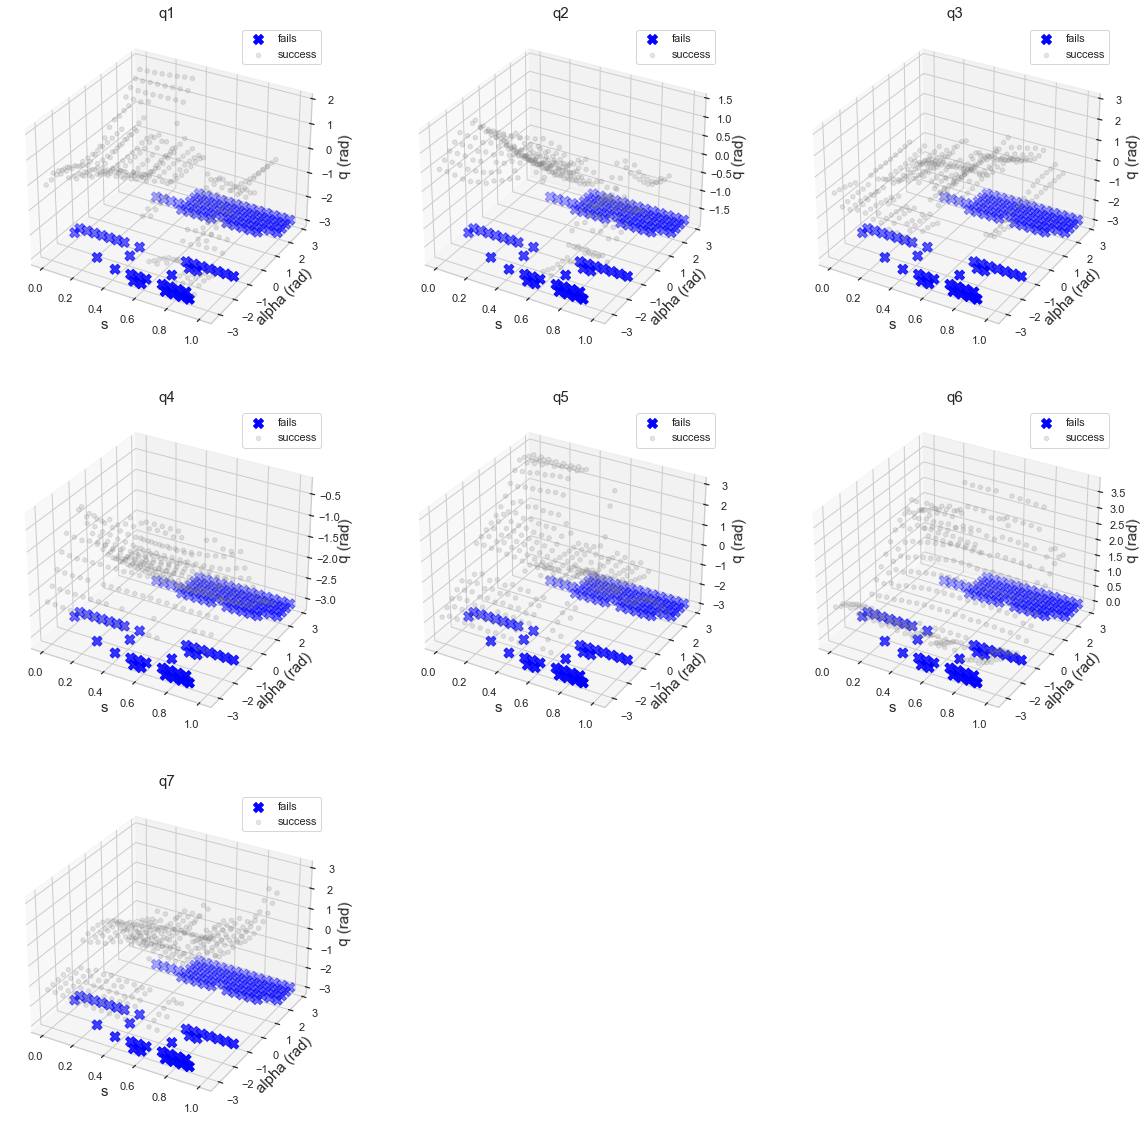

In [26]:
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sol_df=pd.read_csv('q_sol_15.csv',header=0)
#print(sol_df)
#sol_df[sol_df["Success"]==False]
sns.set(style = "whitegrid")

textsize = 15
fig = plt.figure(figsize=(20,20))
#ax = fig.add_subplot(331, projection = '3d')
#print(type(sol_df['q']))
sol_df['q']=convert_str_array(sol_df['q'])
#print(sol_df['q'][0])
for i in range (7):
    ax = fig.add_subplot(3,3,i+1, projection = '3d')
    ax.set_xlim(auto=True)
    ax.set_xlabel("s",size=textsize)
    ax.set_ylim(auto=True)
    ax.set_ylabel("alpha (rad)",size=textsize)
    ax.set_zlim(auto=True)
    ax.set_zlabel("q (rad)",size=textsize)
    ax.set_title("q"+str(i+1),size=textsize)
    x_false = sol_df[sol_df['success']==False]['s']
    x_success = sol_df[sol_df['success']==True]['s']
    y_false = sol_df[sol_df['success']==False]['alpha']
    y_success = sol_df[sol_df['success']==True]['alpha']
    z_false=[x[i] for x in sol_df[sol_df['success']==False]['q']]
    z_success=[x[i] for x in sol_df[sol_df['success']==True]['q']]
    ax.scatter(x_false, y_false, panda.qlim[0][i],marker='X',color='blue',s=100, label="fails")
    ax.scatter(x_success, y_success, z_success,color='gray',alpha=0.2, label="success")
    ax.legend()
plt.show()

### Verify with FK


Plotting Trajectory depending on found solutions 


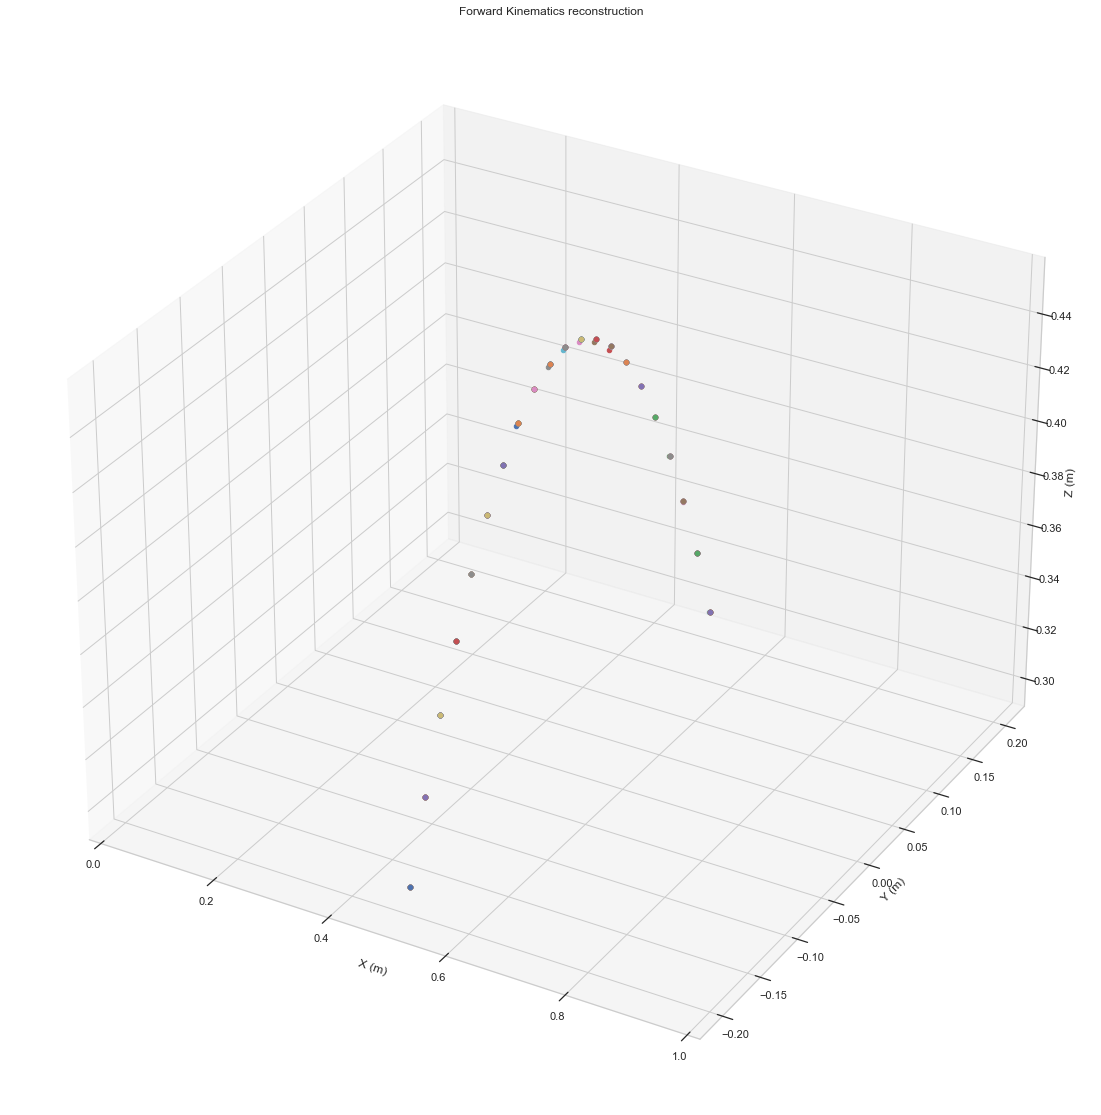

In [32]:
print('\nPlotting Trajectory depending on found solutions ')

fig=plt.figure(figsize=(20,20))

ax = plt.axes(projection='3d')
ax.set_xlim([0,1])
ax.set_xlabel("X (m)")
ax.set_ylim(auto=True)
ax.set_ylabel("Y (m)")
ax.set_zlim(auto=True)
ax.set_zlabel("Z (m)")
ax.set_title("Forward Kinematics reconstruction")
#for qi in sol_df[sol_df['alpha']==0][sol_df['success']==True]['q']:
for qi in sol_df[sol_df['success']==True]['q']:
    #print(qi)
    X_i=panda.fkine(qi).t
    s_i=s_list[i]
    #print(X_i)
    ax.scatter(X_i[0],X_i[1],X_i[2])
plt.show()

### Study Null-Space

In [ ]:
#J0 = panda.jacob0(sol_tab[0][0])
#J0inv=np.linalg.pinv(J0)
#Id7=np.eye(J0inv.shape[0])
#null_space_matrix = Id7 - J0inv.dot(J0)

In [ ]:
#q_dot_null = np.array([1,1,1,0,1,1,1])

In [ ]:
#null_space_matrix.dot(q_dot_null)

### Study Jacobian singularities (rank of the matrix)

In [ ]:
#u_J0, d_J0, v_J0 = np.linalg.svd(J0)

In [ ]:
#rank_J0 = np.linalg.matrix_rank(J0)
#if rank_J0 == 6:
#   print("J0 is full rank matrix")

In [ ]:

print('\nCompute Jacobian Singularities around the computed Wireloop')

d_J0_tab=[]
d_J0_alpha_tab=[]
rank_J0_tab=[]
rank_J0_alpha_tab=[]
for j in range(s_list.size):
        for k in range(alpha_list.size):
            J0 = panda.jacob0(sol_tab[j][k])
            u_J0, d_J0, v_J0 = np.linalg.svd(J0)
            rank_J0 = np.linalg.matrix_rank(J0)
            #print(rank_J0)
            if rank_J0 != 6:
                print("\tJacobian is degenerated for result with: \ts = ",s_list[j], ",\talpha = ",alpha_list[k])
            d_J0_alpha_tab.append(d_J0)
            rank_J0_alpha_tab.append(rank_J0)
            
        rank_J0_tab.append(rank_J0_alpha_tab)
        d_J0_tab.append(d_J0_alpha_tab)

# Robot Cartesian Workspace

### Define Workspace hull

In [213]:
working_cube=np.array([[-0.9,0.9],[-0.9,0.9],[-0.4,1.2]]) # [[xmin,xmas],[ymin,ymax],[zmin,zmax]]
nb_points_cart=[10,10,10] #[nb_pts X,nb_pts Y, nb_pts Z]

RPY_tab=np.array([[0,0,0], # R_F
              [0,np.pi/2,0], # R_D
              [0,-np.pi/2,0], # R_U
              [0,0,np.pi/2], # R_L
              [0,0,-np.pi/2], # R_R    
              [0,0,np.pi]]) # R_B

nb_tests=nb_points_cart[0]*nb_points_cart[1]*nb_points_cart[2]*RPY_tab.shape[0]

print("Nombre de tests: ",nb_tests)

Nombre de tests:  6000


### From IK with cartesian space sampling

In [214]:
ws_cart_df=pd.DataFrame(columns=['X','Y','Z','Roll','Pitch','Yaw','success'])
residual_max = 1e-5

#IK_cart_sol=np.array((nb_tests,7))
IK_cart_sol=[]


x_cart_step=(working_cube[0][1]-working_cube[0][0])/(nb_points_cart[0]-1)
x_cart_tab=np.arange(working_cube[0][0],working_cube[0][1]+x_cart_step,x_cart_step)

y_cart_step=(working_cube[1][1]-working_cube[1][0])/(nb_points_cart[1]-1)
y_cart_tab=np.arange(working_cube[1][0],working_cube[1][1]+y_cart_step,y_cart_step)

z_cart_step=(working_cube[2][1]-working_cube[2][0])/(nb_points_cart[2]-1)
z_cart_tab=np.arange(working_cube[2][0],working_cube[2][1]+z_cart_step,z_cart_step)

print('x_cart_tab = ',x_cart_tab)
print('y_cart_tab = ',y_cart_tab)
print('z_cart_tab = ',z_cart_tab)
# INITIAL GUESS TO IMPROVE !

q_ini=q_neutral
ind=0
for x_i in range(x_cart_tab.size):
    for y_i in range(y_cart_tab.size):
        for z_i in range(z_cart_tab.size):
            for rpy_i in RPY_tab:
                percentage=(ind/nb_tests*100)
                print(f'Plotting Points: {percentage:.6f} %', end='\r')
                ind+=1
                
                x=x_cart_tab[x_i]
                y=y_cart_tab[y_i]
                z=z_cart_tab[z_i]
                
                rr=rpy_i[0]
                rp=rpy_i[1]
                ry=rpy_i[2]
                
                R=SE3.Rz(ry) * SE3.Ry(rp) * SE3.Rx(rr)
                
                T=SE3([x,y,z]) * R
                
                sol=q_frame(T,q_neutral) # best results from neutral pose than from previous successful pose
                
                success = (sol.success and sol.residual < residual_max)
                if success:
                    q_ini=sol.q
            
                ws_cart_df=ws_cart_df.append(pd.Series([x,y,z,rr,rp,ry,success], index=ws_cart_df.columns), ignore_index=True)
        z_cart_tab=z_cart_tab[::-1]
    y_cart_tab=y_cart_tab[::-1]


x_cart_tab =  [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
y_cart_tab =  [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]
z_cart_tab =  [-0.4        -0.22222222 -0.04444444  0.13333333  0.31111111  0.48888889  0.66666667  0.84444444  1.02222222  1.2       ]


/home/raphael/.local/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:186: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


### Exporting Workspace in CSV


In [215]:
ws_cart_df.to_csv("workspace_cart_panda.csv")

### Download Dataframes

In [216]:
ws_cart_df=pd.read_csv('workspace_cart_panda.csv',header=0)

#create  success et fail DF
success_df=pd.DataFrame(ws_cart_df[ws_cart_df["success"]==True]).reset_index(drop = True) 
fail_df=pd.DataFrame(ws_cart_df[ws_cart_df["success"]==False]).reset_index(drop = True) 

In [217]:
success_df.index

RangeIndex(start=0, stop=1023, step=1)

In [218]:
#for index in success_df.index:
index=0
restrained_success_df = pd.DataFrame(columns=success_df.columns)
working_df=success_df
while index < working_df.shape[0]:
    print('index = ',index)
    x_i=working_df['X'].loc[index]
    y_i=working_df['Y'].loc[index]
    z_i=working_df['Z'].loc[index]
    
    point_df = working_df[(working_df["X"]==x_i) & (working_df["Y"]==y_i) & (working_df["Z"]==z_i) & (working_df["Yaw"]==0)]
    print("Point DF = ",point_df)
    if point_df.shape[0]==3:
        restrained_success_df=restrained_success_df.append(point_df)
    working_df=working_df.drop(point_df.index).reset_index(drop = True) 
    print("Working DF = ",working_df)
    
    index +=1

restrained_success_df = restrained_success_df.reset_index(drop = True) 
print("New DF = ",restrained_success_df)    

index =  0
Point DF =     Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0         212 -0.9 -0.3  0.311111   0.0 -1.570796  0.0     True
Working DF =        Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0            266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1            272 -0.9 -0.1  0.488889   0.0 -1.570796  0.0     True
2            326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
3            332 -0.9  0.1  0.311111   0.0 -1.570796  0.0     True
4            338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
...          ...  ...  ...       ...   ...       ...  ...      ...
1017        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
1018        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
1019        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
1020        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
1021        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[1022 rows x 8 columns]
index 

Point DF =      Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
26         944 -0.7 -0.1 -0.044444   0.0 -1.570796  0.0     True
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
993        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
994        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
995        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
996        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
997        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[998 rows x 8 columns]
index =  27
Point DF =      

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
980        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
981        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
982        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
983        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
984        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[985 rows x 8 columns]
index =  58
Point DF =      Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
58        1454 -0.5 -0.1 -0.044444   0.0 -1.570796  0.0     True
Working DF =    

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
957        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
958        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
959        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
960        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
961        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[962 rows x 8 columns]
index =  87
Point DF =      Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
87        1568 -0.5  0.3 -0.222222   0.0 -1.570796  0.0     True
Working DF =    

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
925        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
926        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
927        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
928        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
929        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[930 rows x 8 columns]
index =  113
Point DF =  Empty DataFrame
Columns: [Unnamed: 0, X, Y, Z, Roll, Pitch, Yaw, success]
Index: []
Working DF =       Unnamed: 0    X    Y         Z  Roll     P

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
877        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
878        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
879        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
880        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
881        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[882 rows x 8 columns]
index =  140
Point DF =       Unnamed: 0    X    Y    Z  Roll  Pitch  Yaw  success
140        2094 -0.3  0.1  1.2   0.0    0.0  0.0     True
Working DF =       Unnamed: 0

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
855        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
856        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
857        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
858        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
859        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[860 rows x 8 columns]
index =  169
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
169        2203 -0.3 -0.3  0.844444   0.0  1.570796  0.0     True
170        22

[851 rows x 8 columns]
index =  199
Point DF =  Empty DataFrame
Columns: [Unnamed: 0, X, Y, Z, Roll, Pitch, Yaw, success]
Index: []
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
846        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
847        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
848        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
849        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
850        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[851 rows x 8 columns]
index =  200
Point DF =       Unnamed:

Point DF =  Empty DataFrame
Columns: [Unnamed: 0, X, Y, Z, Roll, Pitch, Yaw, success]
Index: []
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
833        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
834        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
835        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
836        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
837        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[838 rows x 8 columns]
index =  231
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pit

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
796        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
797        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
798        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
799        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
800        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[801 rows x 8 columns]
index =  257
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
257        2736 -0.1  0.1  0.133333   0.0  0.000000  0.0     True
258        27

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
752        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
753        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
754        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
755        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
756        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[757 rows x 8 columns]
index =  284
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
284        2894 -0.1  0.7 -0.044444   0.0 -1.570796  0.0     True
Working DF = 

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
694        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
695        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
696        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
697        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
698        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[699 rows x 8 columns]
index =  310
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
309        3229  0.1  0.3 -0.222222   0.0  1.570796  0.0     True
310        32

Point DF =  Empty DataFrame
Columns: [Unnamed: 0, X, Y, Z, Roll, Pitch, Yaw, success]
Index: []
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
658        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
659        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
660        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
661        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
662        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[663 rows x 8 columns]
index =  338
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pit

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
645        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
646        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
647        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
648        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
649        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[650 rows x 8 columns]
index =  368
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
368        3787  0.3 -0.3  1.022222   0.0  1.570796  0.0     True
Working DF = 

Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
596        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
597        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
598        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
599        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
600        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[601 rows x 8 columns]
index =  393
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
393        3973  0.3  0.3 -0.044444   0.0  1.570796  0.0     True
394        39

417        4357  0.5  0.5  0.666667   0.0  1.570796  0.0     True
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
555        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
556        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
557        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
558        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
559        5737  0.9 -0.1  0.133333   0.0  1.570796  0.0     True

[560 rows x 8 columns]
index =  417
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
417        43

[518 rows x 8 columns]
index =  442
Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
442        4590  0.5 -0.3  0.488889   0.0  0.000000  0.0     True
443        4591  0.5 -0.3  0.488889   0.0  1.570796  0.0     True
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
511        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
512        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
513        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
514        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
515        573

Point DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
466        5184  0.7  0.3  0.311111   0.0  0.000000  0.0     True
467        5185  0.7  0.3  0.311111   0.0  1.570796  0.0     True
Working DF =       Unnamed: 0    X    Y         Z  Roll     Pitch  Yaw  success
0           266 -0.9 -0.1  0.311111   0.0 -1.570796  0.0     True
1           326 -0.9  0.1  0.488889   0.0 -1.570796  0.0     True
2           338 -0.9  0.1  0.133333   0.0 -1.570796  0.0     True
3           746 -0.7  0.5  0.311111   0.0 -1.570796  0.0     True
4           758 -0.7  0.5  0.666667   0.0 -1.570796  0.0     True
..          ...  ...  ...       ...   ...       ...  ...      ...
479        5665  0.9  0.1  0.311111   0.0  1.570796  0.0     True
480        5671  0.9  0.1  0.488889   0.0  1.570796  0.0     True
481        5725  0.9 -0.1  0.488889   0.0  1.570796  0.0     True
482        5731  0.9 -0.1  0.311111   0.0  1.570796  0.0     True
483        5737  0.9 -0.1  0.133333   0.0  1.57079

### Success Dataframe

In [219]:
uvw_success_df=pd.DataFrame(columns=['X','Y','Z','U','V','W'])
print("Number of success: ",success_df.shape[0],' /',success_df.shape[0]+fail_df.shape[0])
for index in success_df.index:
    
    x_i=success_df['X'].loc[index]
    y_i=success_df['Y'].loc[index]
    z_i=success_df['Z'].loc[index]
    
    rr_i = success_df['Roll'].loc[index]
    rp_i = success_df['Pitch'].loc[index]
    ry_i = success_df['Yaw'].loc[index]
    frame = SE3.Rz(ry_i) * SE3.Ry(rp_i) * SE3.Rx(rr_i)
    u_i = frame.R[0][0]
    v_i = frame.R[1][0]
    w_i = frame.R[2][0]
    
    uvw_success_df=uvw_success_df.append(pd.Series([x_i,y_i,z_i,u_i,v_i,w_i], index=uvw_success_df.columns), ignore_index=True)

Number of success:  1023  / 6000


### Restrained Success Dataframe

In [220]:
uvw_rest_success_df=pd.DataFrame(columns=['X','Y','Z','U','V','W'])
print("Number of success: ",success_df.shape[0],' /',success_df.shape[0]+fail_df.shape[0])
print("Number of useful success: ",restrained_success_df.shape[0],' /',success_df.shape[0])
for index in restrained_success_df.index:
    
    x_i=restrained_success_df['X'].loc[index]
    y_i=restrained_success_df['Y'].loc[index]
    z_i=restrained_success_df['Z'].loc[index]
    
    rr_i = restrained_success_df['Roll'].loc[index]
    rp_i = restrained_success_df['Pitch'].loc[index]
    ry_i = restrained_success_df['Yaw'].loc[index]
    frame = SE3.Rz(ry_i) * SE3.Ry(rp_i) * SE3.Rx(rr_i)
    u_i = frame.R[0][0]
    v_i = frame.R[1][0]
    w_i = frame.R[2][0]
    
    uvw_rest_success_df=uvw_rest_success_df.append(pd.Series([x_i,y_i,z_i,u_i,v_i,w_i], index=uvw_rest_success_df.columns), ignore_index=True)

Number of success:  1023  / 6000
Number of useful success:  195  / 1023


### Fail Dataframe

In [221]:
uvw_fail_df=pd.DataFrame(columns=['X','Y','Z','U','V','W'])
print("Number of fails: ",fail_df.shape[0],' /',success_df.shape[0]+fail_df.shape[0])
for index in fail_df.index:
    
    x_i=fail_df['X'].loc[index]
    y_i=fail_df['Y'].loc[index]
    z_i=fail_df['Z'].loc[index]
    
    rr_i = fail_df['Roll'].loc[index]
    rp_i = fail_df['Pitch'].loc[index]
    ry_i = fail_df['Yaw'].loc[index]
    frame = SE3.Rz(ry_i) * SE3.Ry(rp_i) * SE3.Rx(rr_i)
    u_i = frame.R[0][0]
    v_i = frame.R[1][0]
    w_i = frame.R[2][0]
    
    uvw_fail_df=uvw_fail_df.append(pd.Series([x_i,y_i,z_i,u_i,v_i,w_i], index=uvw_fail_df.columns), ignore_index=True)

Number of fails:  4977  / 6000


### Plot Workspace

In [226]:
uvw_success_df['X'].min()

-0.9

Success Workspace:
X=[ -0.9 , 0.9000000000000007 ]	Y=[ -0.7 , 0.7000000000000005 ]	Z=[ -0.22222222222222224 , 1.2000000000000002 ]
Restrained Workspace:
X=[ -0.4999999999999999 , 0.5000000000000003 ]	Y=[ -0.4999999999999999 , 0.7000000000000005 ]	Z=[ 0.1333333333333333 , 1.022222222222222 ]


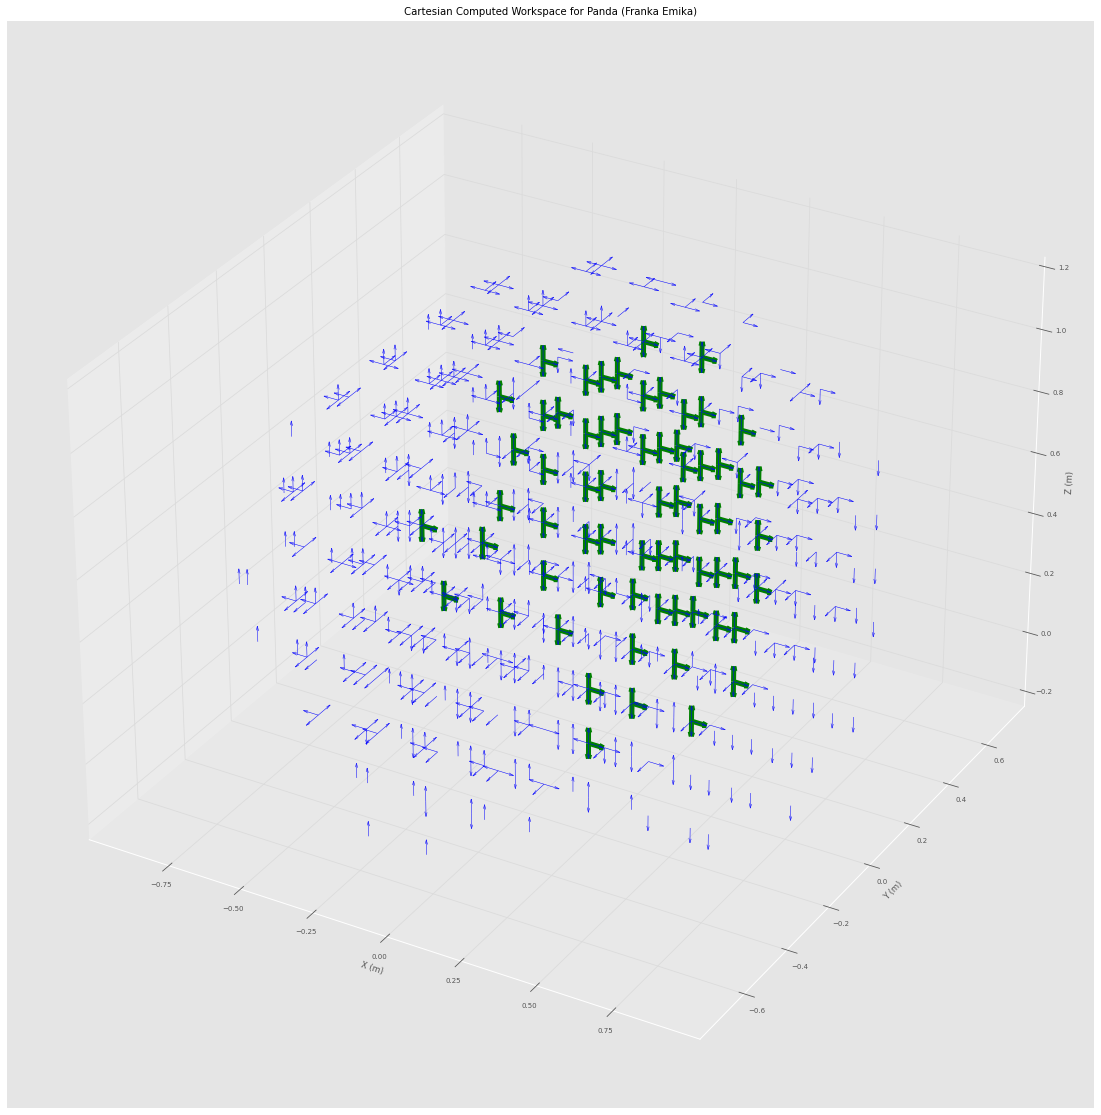

In [229]:
ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')
ax.set_xlim(auto=True)
ax.set_xlabel("X (m)")
ax.set_ylim(auto=True)
ax.set_ylabel("Y (m)")
ax.set_zlim(auto=True)
ax.set_zlabel("Z (m)")
ax.set_title("Cartesian Computed Workspace for Panda (Franka Emika)")

#ax.quiver(uvw_fail_df['X'], uvw_fail_df['Y'], uvw_fail_df['Z'], uvw_fail_df['U'], uvw_fail_df['V'], uvw_fail_df['W'], length=0.05, normalize=True,color='red')
ax.quiver(uvw_success_df['X'], uvw_success_df['Y'], uvw_success_df['Z'], uvw_success_df['U'], uvw_success_df['V'], uvw_success_df['W'], length=0.05, normalize=True,color='blue')
ax.quiver(uvw_rest_success_df['X'], uvw_rest_success_df['Y'], uvw_rest_success_df['Z'], uvw_rest_success_df['U'], uvw_rest_success_df['V'], uvw_rest_success_df['W'], length=0.05, normalize=True,color='green',linewidths=5)
print("Success Workspace:\nX=[",uvw_success_df['X'].min(),",",uvw_success_df['X'].max(),"]\tY=[",uvw_success_df['Y'].min(),",",uvw_success_df['Y'].max(),"]\tZ=[",uvw_success_df['Z'].min(),",",uvw_success_df['Z'].max(),"]")
print("Restrained Workspace:\nX=[",uvw_rest_success_df['X'].min(),",",uvw_rest_success_df['X'].max(),"]\tY=[",uvw_rest_success_df['Y'].min(),",",uvw_rest_success_df['Y'].max(),"]\tZ=[",uvw_rest_success_df['Z'].min(),",",uvw_rest_success_df['Z'].max(),"]")

plt.show()

### From FK with articular space sampling

In [ ]:
cut = 5
print('\nCompute Robot Workspace')

P_tab=[]
ws_art_df=pd.DataFrame(columns=['X','Y','Z','Roll','Pitch','Yaw','success'])
cut_tab=[cut,cut,cut,cut,cut,cut,cut]
q_min=panda.qlim[0]
q_max=panda.qlim[1]
delta_q=q_max-q_min
for i1 in range(cut_tab[0]+1):
    q1 = q_min[0] + i1*delta_q[0]/cut_tab[0]
    #print(q1)
    for i2 in range(cut_tab[1]+1):
        q2 = q_min[1] + i2*delta_q[1]/cut_tab[1]
        for i3 in range(cut_tab[2]+1):
            q3 = q_min[2] + i3*delta_q[2]/cut_tab[2]
            for i4 in range(cut_tab[3]+1):
                q4 = q_min[3] + i4*delta_q[3]/cut_tab[3]
                for i5 in range(cut_tab[4]+1):
                    q5 = q_min[4] + i5*delta_q[4]/cut_tab[4]
                    for i6 in range(cut_tab[5]+1):
                        q6 = q_min[5] + i6*delta_q[5]/cut_tab[5]
                        for i7 in range(cut_tab[6]+1):
                            q7 = q_min[6] + i7*delta_q[6]/cut_tab[6]
                            q_test=[q1,q2,q3,q4,q5,q6,q7]
                            P_tab.append(panda.fkine(q_test).t)
print("Nombre de points: ",len(P_tab))

In [379]:
cut = 4
nb_tests= (cut+1)**7
print('\nCompute Robot Workspace')

P_tab=[]
ws_art_df=pd.DataFrame(columns=['q1','q2','q3','q4','q5','q6','q7','X','Y','Z','U','V','W'])
cut_tab=[cut,cut,cut,cut,cut,cut,cut]
q_min=panda.qlim[0]
q_max=panda.qlim[1]
delta_q=q_max-q_min
ind=0
for i1 in range(cut_tab[0]+1):
    q1 = q_min[0] + i1*delta_q[0]/cut_tab[0]
    #print(q1)
    for i2 in range(cut_tab[1]+1):
        q2 = q_min[1] + i2*delta_q[1]/cut_tab[1]
        for i3 in range(cut_tab[2]+1):
            q3 = q_min[2] + i3*delta_q[2]/cut_tab[2]
            for i4 in range(cut_tab[3]+1):
                q4 = q_min[3] + i4*delta_q[3]/cut_tab[3]
                for i5 in range(cut_tab[4]+1):
                    q5 = q_min[4] + i5*delta_q[4]/cut_tab[4]
                    for i6 in range(cut_tab[5]+1):
                        q6 = q_min[5] + i6*delta_q[5]/cut_tab[5]
                        for i7 in range(cut_tab[6]+1):
                            
                            percentage=(ind/nb_tests*100)
                            print(f'Plotting Points: {percentage:.6f} %', end='\r')
                            ind+=1
                            q7 = q_min[6] + i7*delta_q[6]/cut_tab[6]
                            
                            q_i=[q1,q2,q3,q4,q5,q6,q7]
                            
                            T_i=panda.fkine(q_i)

                            x=T_i.t[0]
                            y=T_i.t[1]
                            z=T_i.t[2]
                            
                            u = T_i.R[0][0]
                            v = T_i.R[1][0]
                            w = T_i.R[2][0]

                            ws_art_df=ws_art_df.append(pd.Series([q1,q2,q3,q4,q5,q6,q7,x,y,z,u,v,w], index=ws_art_df.columns), ignore_index=True)
                   
ws_art_df.to_csv("workspace_art_panda.csv")


Compute Robot Workspace


### Plot Articular Workspace

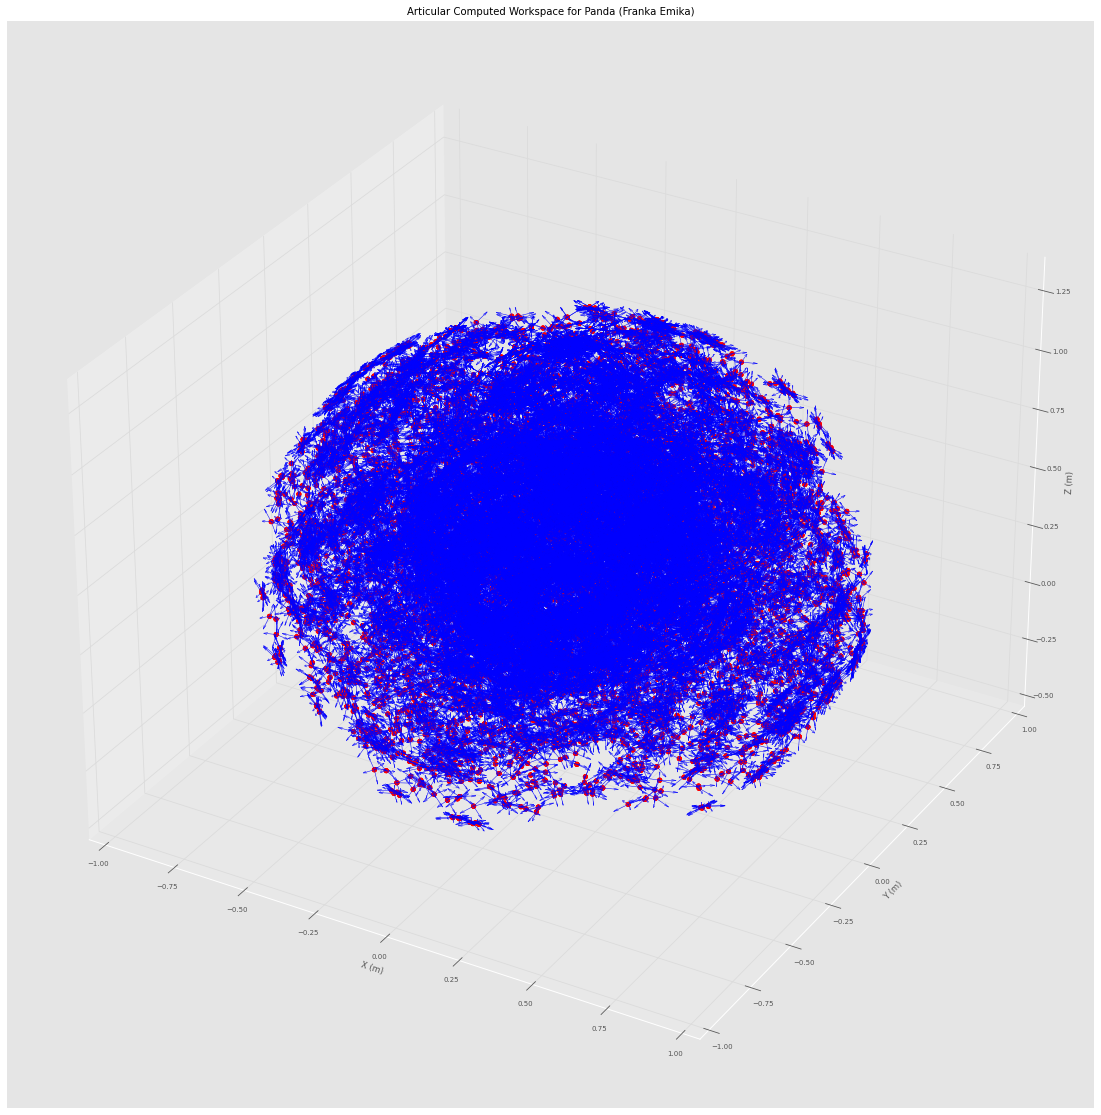

In [3]:
ws_art_df=pd.read_csv('workspace_art_panda.csv',header=0)

ax = plt.figure(figsize=(20,20)).add_subplot(projection='3d')
ax.set_xlim(auto=True)
ax.set_xlabel("X (m)")
ax.set_ylim(auto=True)
ax.set_ylabel("Y (m)")
ax.set_zlim(auto=True)
ax.set_zlabel("Z (m)")
ax.set_title("Articular Computed Workspace for Panda (Franka Emika)")

#ax.quiver(uvw_fail_df['X'], uvw_fail_df['Y'], uvw_fail_df['Z'], uvw_fail_df['U'], uvw_fail_df['V'], uvw_fail_df['W'], length=0.05, normalize=True,color='red')
ax.quiver(ws_art_df['X'], ws_art_df['Y'], ws_art_df['Z'], ws_art_df['U'], ws_art_df['V'], ws_art_df['W'], length=0.05, normalize=True,color='blue')
ax.scatter(ws_art_df['X'], ws_art_df['Y'], ws_art_df['Z'], color='red')

plt.show()

In [373]:
T_i=panda.fkine(q_neutral)


T_test=SE3.Ry(3)#*SE3.Ry(2)*SE3.Rx(1)
print(T_test)
x=T_i.t[0]
y=T_i.t[1]
z=T_i.t[2]

rr=T_test.rpy()[0]
rp=T_test.rpy()[1]
ry=T_test.rpy()[2]
print(rr)
print(rp)
print(ry)

  -0.99      0         0.1411    0         
   0         1         0         0         
  -0.1411    0        -0.99      0         
   0         0         0         1         

3.141592653589793
0.14159265358979323
3.141592653589793


In [ ]:
panda.qlim

In [ ]:
test=np.array([0,0,0,0,0,0,0])
if(test>panda.qlim[0]).any():
    print("che")

### Compute Convex Hull

In [ ]:
P_array=np.array(P_tab)
hull = ConvexHull(P_array)

### Plot Workspace and convex hull

In [ ]:
fig_cartesian=plt.figure(figsize=(40,40))

ax_cartesian = plt.axes(projection ='3d')
ax_cartesian.set_xlim(auto=True)
ax_cartesian.set_ylim(auto=True)
ax_cartesian.set_zlim(auto=True)
ax_cartesian.set_xlabel("X (m)")
ax_cartesian.set_ylabel("Y (m)")
ax_cartesian.set_zlabel("Z (m)")
ax_cartesian.set_title('Robot Workspace')

# Plot points
for p_i in range(len(P_tab)):
    percentage=(p_i/len(P_tab)*100)
    print(f'Plotting Points: {percentage:.2f} %', end='\r')
    ax_cartesian.scatter(P_tab[p_i][0],P_tab[p_i][1],P_tab[p_i][2],color='red')

print('\nPoints plotted')

# Compute Convex Hull
print('Computing Convex Hull')
P_array=np.array(P_tab)
hull = ConvexHull(P_array)
print('Plotting Convex Hull')
for simplex in hull.simplices:
    ax_cartesian.plot3D(P_array[simplex, 0], P_array[simplex, 1], P_array[simplex, 2], 'k-')

print('Convex Hull plotted')
print('\nShowing results')
plt.show()

### Place Wireloop in the convex hull

In [ ]:
fig_convexhull=plt.figure(figsize=(40,40))
ax_convexhull = plt.axes(projection ='3d')

for simplex in hull.simplices:
    ax_convexhull.plot3D(P_array[simplex, 0], P_array[simplex, 1], P_array[simplex, 2], 'k-')
for s_i in s_list:
    ax_convexhull.scatter(X_r(s_i),Y_r(s_i),Z_r(s_i), color='blue')
    
    

plt.show()

### Check if some points are in the convex hull

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, delaunay_plot_2d, tsearch

rng = np.random.default_rng()

pts = rng.random((20, 2))

tri = Delaunay(pts)
_ = delaunay_plot_2d(tri)

loc = rng.uniform(0.2, 0.8, (5, 2))

s = tsearch(tri, loc)
print(pts)
print( tri.simplices)
print(s)
plt.triplot(pts[:, 0], pts[:, 1], tri.simplices[s], 'b-', mask=s==-1)

plt.scatter(loc[:, 0], loc[:, 1], c='r', marker='x')

plt.show()

In [ ]:

import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, delaunay_plot_2d, tsearch
fig=plt.figure(figsize=(10,10))
ax= plt.axes(projection ='3d')

rng = np.random.default_rng()

pts = rng.random((20, 3))
hull = ConvexHull(pts)
pts_cvx_list=[]
for i in range (hull.simplices.shape[0]):
    pts_cvx_list.append([pts[hull.simplices[i][0],0], pts[hull.simplices[i][1],1], pts[hull.simplices[i][2],2]])
pts_cvx = np.array(pts_cvx_list)
tri = Delaunay(pts_cvx)

loc = rng.uniform(0.2, 0.8, (5, 3))

s = tsearch(tri, loc)
#print('pts:\n',pts)
#print('pts 0 :\n',pts[0])
#print( 'tri.simplices:\n',tri.simplices)
#print( 'tri.simplices S:\n',tri.simplices[s])
#print('s:\n',s)
#plt.triplot(pts[:, 0], pts[:, 1], tri.simplices[s], 'b-', mask=s==-1)

#plt.scatter(loc[:, 0], loc[:, 1], c='r', marker='x')

#plt.show()


print(tri.simplices)
for simplex in tri.simplices:
#simplex=tri.simplices[0]
    #print(simplex)
    ax.plot3D(pts_cvx[simplex,0],pts_cvx[simplex,1],pts_cvx[simplex,2], 'g-')
for simplex in tri.simplices[s]:
#simplex=tri.simplices[0]
#print(simplex)
    ax.plot3D(pts_cvx[simplex,0],pts_cvx[simplex,1],pts_cvx[simplex,2], 'b-')
for point in loc:
    ax.scatter(point[0], point[1],point[2], 'r-')

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, delaunay_plot_2d, tsearch
fig=plt.figure(figsize=(10,10))
ax= plt.axes(projection ='3d')

rng = np.random.default_rng()

pts = rng.random((20, 3))
hull = ConvexHull(pts)

tri = Delaunay(hull.simplices)
#_ = delaunay_plot_2d(tri)

loc = rng.uniform(0.2, 0.8, (5, 3))

s = tsearch(tri, loc)
print('pts:\n',pts)
print('pts 0 :\n',pts[0])
print( 'tri.simplices:\n',tri.simplices)
print( 'tri.simplices S:\n',tri.simplices[s])
print('s:\n',s)
#plt.triplot(pts[:, 0], pts[:, 1], tri.simplices[s], 'b-', mask=s==-1)

#plt.scatter(loc[:, 0], loc[:, 1], c='r', marker='x')

#plt.show()

results = tsearch(tri, pts)
shapes=tri.simplices

for simplex in tri.simplices:
#simplex=tri.simplices[0]
#print(simplex)
    ax.plot3D(pts[simplex,0],pts[simplex,1],pts[simplex,2], 'g-')
for simplex in tri.simplices[s]:
#simplex=tri.simplices[0]
#print(simplex)
    ax.plot3D(pts[simplex,0],pts[simplex,1],pts[simplex,2], 'b-')
for point in loc:
    ax.scatter(point[0], point[1],point[2], 'r-')

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from scipy.spatial import Delaunay, delaunay_plot_2d, tsearch

rng = np.random.default_rng()

pts = rng.random((20, 2))
pts = np.array([[float(X_r(0)), float(Y_r(0)), float(Z_r(0))],[float(X_r(1)), float(Y_r(1)), float(Z_r(1))],[float(X_r(0.3)) ,float(Y_r(0.3)) ,float(Z_r(0.3))],[float(X_r(0.6) ),float(Y_r(0.6)) ,float(Z_r(0.6))],[float(X_r(0.8)),float(Y_r(0.8)) ,float(Z_r(0.8))],[float(X_r(0.15)) ,float(Y_r(0.15)) ,float(Z_r(0.15))]])
print(pts)
tri = Delaunay(P_array)

fig_convexhull=plt.figure(figsize=(10,10))
ax_convexhull = plt.axes(projection ='3d')

results = tsearch(tri, pts)
shapes=tri.simplices
print(tri.simplices)
print(s)
#for simplex in tri.simplices:
    #ax_convexhull.plot3D(P_array[simplex, 0], P_array[simplex, 1], P_array[simplex, 2], 'k-')

In [ ]:
tri.simplices

### Display in color

from colour import Color
c1 = Color("green")

c2 = Color("red")

gradient = list(c1.range_to(c2, 100))

grad_rgb = [x.rgb for x in gradient]

grad_rgb_255 = [list(map(lambda x: int(x*255), i)) for i in grad_rgb]

palette = np.array(grad_rgb_255)


ind = np.linspace(0,99,100, dtype=int).reshape(1,100)

fig = plt.figure(figsize=(8,2))

ax = fig.add_subplot(111)

ax.imshow(palette[ind])

ax.axis("off")

plt.show()

### Solve optimization function to find best path

q1_ = sp.Symbol('q1') 
q2_ = sp.Symbol('q2')
q3_ = sp.Symbol('q3')
q4_ = sp.Symbol('q4')
q5_ = sp.Symbol('q5')
q6_ = sp.Symbol('q6')
q7_ = sp.Symbol('q7')
q_=[q1_,q2_,q3_,q4_,q5_,q6_,q7_]

ry_test=SE3(0.2074,0.1934,0.1747)*SE3.Ry(0.5)
print(ry_test)
q_test=panda.ikine_LM(ry_test,q0=q_neutral).q
print(q_test)
test=panda.fkine(q_test)
print(test)
print(q_test>panda.qlim[0])
print(q_test<panda.qlim[1])

Xtest=panda.fkine(q_test)
print(Xtest)
qsol=panda.ikine_LM(Xtest,q0=(panda.qlim[0]+panda.qlim[1])/2)[0]

print(qsol)
Xsol=panda.fkine(qsol)

print(Xsol)

In [27]:
def MGD_(q_):
    return panda.fkine(q_)
def X_(q_):
    return panda.fkine(q_).t[0]
def Y_(q_):
    return panda.fkine(q_).t[1]
def Z_(q_):
    return panda.fkine(q_).t[2]
def Theta_y_(q_):
    return sp.asin(-MGD_(q_).R[2,0])
def J0_(q_):
    return panda.jacob0(q_)

def MGD(q):
    return panda.fkine(q)
def X(q):
    return panda.fkine(q).t[0]
def Y(q):
    return panda.fkine(q).t[1]
def Z(q_):
    return panda.fkine(q).t[2]
def Tcr(q):
    #Twc = current_path_frame
    #Tcr = Twc.inv() * MGD(q)
    Tcr = SE3.Ry(Theta_y(q))œ
    return Tcr

def Eq(q):
    Tcr = SE3.Ry(Theta_y(q))
    Twc = current_path_frame
    Eq = Tcr.inv() * Twc.inv() * MGD(q)
    #print(Eq)
    return Eq

def Theta_y(q):
    #print("Tcr =",Tcr(q))
    # Compute r31
    r13=Tcr(q).R[0,2]
    if(r13>1):
        r13=1
    elif(r13<-1):
        r13=-1
        
    # Compute r11
    r11=Tcr(q).R[0,0]
    if(r11>1):
        r11=1
    elif(r11<-1):
        r11=-1
        
    # Compute r31
    r31=Tcr(q).R[0,0]
    if(r31>1):
        r31=1
    elif(r31<-1):
        r31=-1
        
    theta_y = np.arctan2(r13, r11) 
    theta_y = np.arcsin(-r31) 
    #print('theta_y =',theta_y)
    # tester le calcul avec la fonction "magique" de David
    return theta_y
def oppTheta_y(q):
    return -Theta_y(q)
def J0(q):
    return panda.jacob0(q)

In [28]:
SE3.Ry(0.5)

   0.8776    0         0.4794    0         
   0         1         0         0         
  -0.4794    0         0.8776    0         
   0         0         0         1         


### Constraints

In [35]:
### BOUNDS

#lb = panda.qlim[0]
#ub = panda.qlim[1]
lb = np.array([-np.pi,-np.pi,-np.pi,-np.pi,-np.pi,-np.pi,-np.pi])
ub = np.array([np.pi,np.pi,np.pi,np.pi,np.pi,np.pi,np.pi])
print(lb)
print(ub)
bounds = Bounds(lb,ub)

### NON LINEAR CONSTRAINTS
def cons_f(q):
    return np.array([MGD(q).t[0],
                    MGD(q).t[1],
                    MGD(q).t[2],
                    MGD(q).rpy()[0],
                    MGD(q).rpy()[1],
                    MGD(q).rpy()[2]])
def cons_J(q):
    return panda.jacob0(q)
def cons_H(q,qd):
    return panda.hessian0(q)

def Tcr_trans(q):
    t0 = Tcr(q).t[0]
    t1 = Tcr(q).t[1]
    t2 = Tcr(q).t[2]
    trans_cons = np.array([t0,t1,t2])
    print("trans_cons=",trans_cons)
    return trans_cons

def Tcr_rot(q):
    r12=Tcr(q).R[0,1]
    r21=Tcr(q).R[1,0]
    r23=Tcr(q).R[1,2]
    r32=Tcr(q).R[2,1]
    r22=Tcr(q).R[1,1]
    rot_cons = np.array([r12,r21,r23,r32,r22])
    print("rot_cons=",rot_cons)
    return rot_cons

def Eq_values(q):
    t0 = Eq(q).t[0]
    t1 = Eq(q).t[1]
    t2 = Eq(q).t[2]
    r11 = Eq(q).R[0,0]
    r22 = Eq(q).R[1,1]
    r33 = Eq(q).R[2,2]
    values = np.array([t0,t1,t2,r11,r22,r33])
    return values

def Tcr_values_old(q):
    t0 = Tcr(q).t[0]
    t1 = Tcr(q).t[1]
    t2 = Tcr(q).t[2]
    r12=Tcr(q).R[0,1]
    r21=Tcr(q).R[1,0]
    r23=Tcr(q).R[1,2]
    r32=Tcr(q).R[2,1]
    values = np.array([t0,t1,t2,r12,r21,r23,r32])
    return values

def Tcr_constraints_trans():
    #constraints = np.array([Tcr(q).t[0],
    #                        Tcr(q).t[1],
    #                        Tcr(q).t[2]])
    ub = np.array([0,0,0])
    lb = np.array([0,0,0])
    
    tcr_cons_t = NonlinearConstraint(Tcr_trans, lb, ub)
    return tcr_cons_t

def Tcr_constraints_rot():
    #constraints = np.array([Tcr(q).t[0],
    #                        Tcr(q).t[1],
    #                        Tcr(q).t[2]])
    ub = np.array([0,0,0,0,1])
    lb = np.array([0,0,0,0,1])
    
    tcr_cons_r = NonlinearConstraint(Tcr_rot, lb, ub)
    return tcr_cons_r

def Eq_constraints():
    
    # do not contain constraint on value 1 for r22 !
    tol = 1e-8
    ub = np.array([tol,tol,tol,tol+1,tol+1,tol+1])
    lb = - np.array([tol,tol,tol,tol-1,tol-1,tol-1])
    
    tcr_cons = NonlinearConstraint(Eq_values, lb, ub)
    return tcr_cons

def Tcr_constraints_old():
    
    # do not contain constraint on value 1 for r22 !
    tol = 1e-8
    ub = np.array([tol,tol,tol,tol,tol,tol,tol])
    lb = -ub
    
    tcr_cons = NonlinearConstraint(Tcr_values, lb, ub)
    return tcr_cons
    
    

def matrix_form_constraints():
    #constraints = np.array([Tcr(q).t[0],
    #                        Tcr(q).t[1],
    #                        Tcr(q).t[2]])
    ub = np.array([0,0,0,0,0])
    lb = np.array([0,0,0,0,0])
    
    mfc = NonlinearConstraint(Tcr_rot, lb, ub)
    return mfc

def equality_constraints(s):
    #lb_nl = np.array([SE3(PathFrame(s),check=False).t[0],
     #               SE3(PathFrame(s),check=False).t[1],
      #              SE3(PathFrame(s),check=False).t[2],
       #             SE3(PathFrame(s),check=False).rpy()[0],
        #            SE3(PathFrame(s),check=False).rpy()[1],
         #           SE3(PathFrame(s),check=False).rpy()[2]])
    theta_y_min = -3.14
    theta_y_max = 3.14
    lb_nl = np.array([(SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).t[0],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).t[1],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).t[2],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).rpy()[0],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).rpy()[1],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_min)).rpy()[2]])
    ub_nl = np.array([(SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).t[0],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).t[1],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).t[2],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).rpy()[0],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).rpy()[1],
                    (SE3(PathFrame(s),check=False)*SE3.Ry(theta_y_max)).rpy()[2]])
    #print(cons_f)
    #nlc = NonlinearConstraint(cons_f, lb_nl, ub_nl, jac=cons_J, hess=cons_H)
    nlc = NonlinearConstraint(cons_f, lb_nl, ub_nl)
    print(nlc)
    return nlc

[-3.14159265 -3.14159265 -3.14159265 -3.14159265 -3.14159265 -3.14159265 -3.14159265]
[3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265 3.14159265]


In [39]:
bounds

Bounds(array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265]), array([3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265, 3.14159265]))

In [37]:


from scipy.optimize import least_squares,minimize,Bounds

theta_y_lim_df = pd.DataFrame(columns=['s','theta_y_min','theta_y_max'])

s_test=0
ind = 0
for s_i in s_list:
    percentage=(ind/s_list.size*100)
    print(f'Plotting Points: {percentage:.2f} %', end='\r')
    ind+=1
    
    q_init=(panda.qlim[0]+panda.qlim[1])/2
    #q_init=0
    '''print(q_init)
    print(bounds)
    print(nonlinear_constraints(s_test))'''
    
    current_path_frame=SE3(PathFrame(s_i),check=False)
    #print("COMPUTE MINIMAL")
    q_theta_y_min = minimize(Theta_y, q_init, method='trust-constr',bounds=bounds,constraints=Eq_constraints()) 
    
    #print("COMPUTE MAXIMAL")
    q_theta_y_max = minimize(oppTheta_y, q_init, method='trust-constr',bounds=bounds,constraints=Eq_constraints())
    
    print("Min q=",q_theta_y_min.x)
    print("Max q=",q_theta_y_max.x)
    print("Min=",Eq(q_theta_y_min.x))
    print("Max=",Eq(q_theta_y_max.x))
    '''print("\nq_theta_y_min= \n",q_theta_y_min.x)
    print((q_theta_y_min.x>lb).any())
    print((q_theta_y_min.x<ub).any())

    print("MGD:\n",MGD(q_theta_y_min.x))
    print("\nq_theta_y_max= \n",q_theta_y_max.x)
    print((q_theta_y_max.x>lb).any())
    print((q_theta_y_max.x<ub).any())
'''
    #theta_y_min=np.arcsin(-MGD_(q_theta_y_min.x).R[2,0])
    #theta_y_max=np.arcsin(-MGD_(q_theta_y_max.x).R[2,0])
    theta_y_min=Theta_y(q_theta_y_min.x)
    theta_y_max=Theta_y(q_theta_y_max.x)
    
    theta_y_lim_df=theta_y_lim_df.append(pd.Series([s_i,theta_y_min,theta_y_max], index=theta_y_lim_df.columns), ignore_index=True)

    print("\ntheta_y_min= \n",theta_y_min)
    print("\ntheta_y_max= \n",theta_y_max)
    print("\ntheta_y_min 2= \n",q_theta_y_min.fun)
    print("\ntheta_y_max 2= \n",-q_theta_y_max.fun)




Min q= [-0.62470395  0.96028491  0.23636374 -1.07114925  0.14191752  0.88984665  0.00471085]
Max q= [-0.50295046  0.94845436  0.03383697 -1.06480877  0.23932865  0.87243702 -0.07993087]
Min=    1         8.721e-09  0.0001508 -5.174e-12  
  -8.723e-09  1         8.442e-09 -5.711e-12  
  -0.0001508 -8.443e-09  1         1.14e-11  
   0         0         0         1         

Max=    1        -1.525e-09 -6.701e-05  0         
   1.525e-09  1        -3.214e-09  0         
   6.701e-05  3.214e-09  1         0         
   0         0         0         1         


theta_y_min= 
 -0.7854735439132324

theta_y_max= 
 -0.7853646563949015

theta_y_min 2= 
 -0.7854735439132324

theta_y_max 2= 
 -0.7853646563949015
Min q= [-0.30349831  0.86081459 -0.23316589 -1.15025288  0.36063549  0.86486313 -0.13422176]
Max q= [-0.11914471  0.92471453 -0.54218276 -1.13085001  0.49946732  0.8058893  -0.26016979]
Min=    1         2.824e-09  8.275e-05  4.476e-13  
  -2.825e-09  1         6.356e-09  4.041e-14  
  -

KeyboardInterrupt: 

In [25]:
theta_y_lim_df.to_csv("theta_y_lim_15_test.csv")

No handles with labels found to put in legend.


    Unnamed: 0     s  theta_y_min  theta_y_max
0            0  0.00    -0.785431    -0.785392
1            1  0.05    -0.785443    -0.785356
2            2  0.10    -0.785426    -0.785398
3            3  0.15    -0.785478    -0.785398
4            4  0.20    -0.785418    -0.785302
5            5  0.25    -0.785469    -0.785398
6            6  0.30    -0.785419    -0.785384
7            7  0.35    -0.785441    -0.785398
8            8  0.40    -0.785435    -0.785358
9            9  0.45    -0.785463    -0.785394
10          10  0.50    -0.785469    -0.785342
11          11  0.55    -0.785425    -0.785313
12          12  0.60    -0.785476    -0.785372
13          13  0.65    -0.785485    -0.785318
14          14  0.70    -0.785437    -0.785364
15          15  0.75    -0.785505    -0.785392
16          16  0.80    -0.785421    -0.785328
17          17  0.85    -0.785449    -0.785346
18          18  0.90    -0.785456    -0.785320
19          19  0.95    -0.785448    -0.785387
20          2

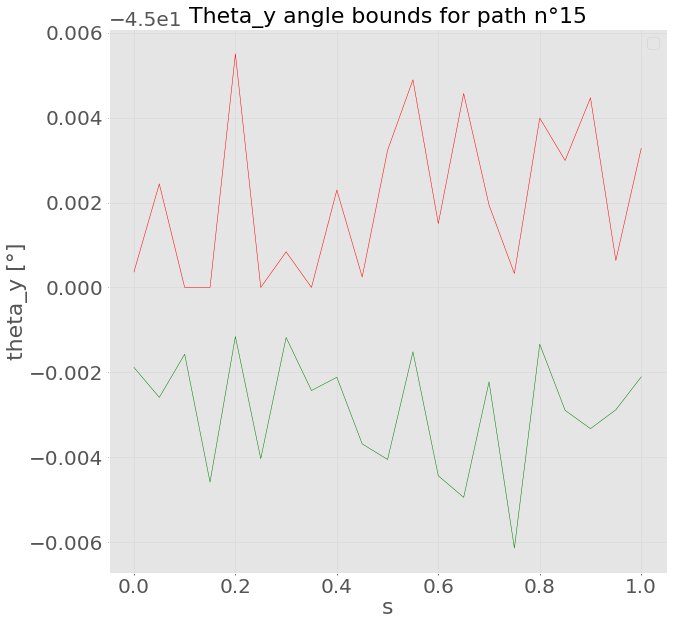

In [13]:
fig = plt.figure(figsize=(10,10))

theta_y_lim_df=pd.read_csv('theta_y_lim_15_test.csv',header=0)

print(theta_y_lim_df)


plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

plt.plot(theta_y_lim_df['s'],theta_y_lim_df['theta_y_min']*180 / np.pi,color='green')
plt.plot(theta_y_lim_df['s'],theta_y_lim_df['theta_y_max']*180 / np.pi,color='red')
plt.xlabel('s',fontsize=22)
plt.ylabel('theta_y [°]',fontsize=22)
plt.title('Theta_y angle bounds for path n°'+str(n_path),fontsize=22)


plt.legend(fontsize='15', title_fontsize='40')
plt.show()